<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Guided Problem Set 13: Double Pendulum</h1>


<a name='section_13_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P13.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_13_1">P13.1 Modeling the System</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_13_1">P13.1 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_13_2">P13.2 Running the Simulation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_13_2">P13.2 Problems</a></td>
    </tr>
</table>



<h3>Learning Objectives</h3>

In this problem set, we will use a numerical simulation to explore the behavior of a **double pendulum.**

As will be done in all Psets for this course, there will be several questions which lead to building a full-fledged simulation of the physical system or computational task under consideration.

<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [6]:
#>>>RUN: P13.0-runcell00

#install the following:

#conda install -c conda-forge imageio
#pip install imageio
#pip3 install torch torchvision torchaudio

In [7]:
#>>>RUN: P13.0-runcell01

from scipy.integrate import odeint
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
import random

<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [8]:
#>>>RUN: P13.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


<a name='section_13_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P13.1 Modeling the System</h2>    

| [Top](#section_13_0) | [Previous Section](#section_13_0) | [Problems](#problems_13_1) | [Next Section](#section_13_2) |


<h3>Overview</h3>

The double pendulum is a system in classical mechanics where one pendulum is attached to the end of another pendulum. Its equations of motion are usually expressed using Lagrangian mechanics and solved numerically, which is what we will do in this problem.

For this example, we will assume that both pendulums have length $\ell=5~\textrm{m}$ and mass $m=1~\textrm{kg}$. The code uses the standard symbol $g$ for the gravitational acceleration $g=9.81$$\textrm{m/s^2}$.

The starting code cell below sets these values for the parameters and defines functions that you can use in the code you will write to answer the questions in this problem. These include:

`theta1/2ddot`: Calculates the angular acceleration of the two pendulums. The inputs are the two angles and angular velocities, as well as the mass, length and $g$.

`ode`: Simply calls the two `ddot` functions.

`energy`: Calculates the total energy of the system. The inputs are an array with the two angles and angular velocities, as well as the mass, length and $g$. Note that this function defines the zero of the two potential energies to be the point where their angles are $90^{\circ}$, i.e. when the two pendulums are exactly horizontal.

In [9]:
#>>>RUN: P13.1-runcell01

#Below is a reworking of
#https://scipython.com/blog/the-double-pendulum/
#https://github.com/zaman13/Double-Pendulum-Motion-Animation/blob/master/Python%20Code/Double_Pendulum_v1.py

## Setting up the differential equations to be solved

def theta1ddot(theta1,theta1dot,theta2,theta2dot,m,ell,g):
        st1t2=np.sin(theta1-theta2)
        ct1t2=np.cos(theta1-theta2)
        term1=-m*ell**2*st1t2*(ct1t2*theta1dot**2 + theta2dot**2)
        term2= m*g*ell*(-2*np.sin(theta1)+np.sin(theta2)*ct1t2)
        denom=m*ell**2*(1+st1t2**2)
        return (term1+term2)/denom

def theta2ddot(theta1,theta1dot,theta2,theta2dot,m,ell,g):
        st1t2=np.sin(theta1-theta2)
        ct1t2=np.cos(theta1-theta2)
        term1=m*ell**2*st1t2*(ct1t2*theta2dot**2 + 2*theta1dot**2)
        term2=2*m*g*ell*(-np.sin(theta2)+np.sin(theta1)*ct1t2)
        denom=m*ell**2*(1+st1t2**2)
        return (term1+term2)/denom


def ode(y, t, l, m, g):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, theta1dot, theta2, theta2dot = y
    t1ddt=theta1ddot(theta1,theta1dot,theta2,theta2dot,m,l,g)
    t2ddt=theta2ddot(theta1,theta1dot,theta2,theta2dot,m,l,g)
    return theta1dot,t1ddt,theta2dot,t2ddt

def energy(y,l,m,g):
    theta1, theta1dot, theta2, theta2dot = y.T # Note the.T transposes it so we can unpack
    ct1t2=np.cos(theta1-theta2)
    U=-2*m*g*l*np.cos(theta1)-m*g*l*np.cos(theta2)
    K=m*l**2*theta1dot**2+m*l**2/2*(theta2dot**2+2*theta1dot*theta2dot*ct1t2)
    return K+U

## set up pendulum parameters
l=5#m
m=1#kg
g=9.8#kgm/s^2

<a name='problems_4_1'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_1) | [Next Section](#section_4_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 13.1.1</span>

When doing the numerical simulations later in this problem, one parameter we can easily calculate is the energy of the system. Before doing any numerics, is energy conserved in this system?


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 13.1.2</span>

Edit the code below to make the necessary arrays `y0_case` and then use those arrays to find the total energy for systems with the following four sets of initial conditions. Report your answers as a list of number with precision 1e-1): `[energy case1, energy case2, energy case3, energy case4]`

Case 1: No initial amplitude, no initial angular velocity\
Case 2: Small initial amplitude of pendulum 1 only (other initial conditions zero): `theta1=0.02*pi`\
Case 3: Larger initial amplitude of both pendulums (angular velocities zero): `theta1=0.3*pi`, `theta2=0.2*pi`\
Case 4: Nearly vertical (angular velocities zero): `theta1=0.9*pi`, `theta2=pi`

In [10]:
#>>>PROBLEM: P13.1.2

# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

#define arrays for the 4 cases by setting the initial conditions in y0,
#e.g., y0_case1=np.array([theta1_case1, theta1dot_case1, theta2_case1, theta2dot_case1])

y0_case1 = np.array([0, 0, 0, 0])
y0_case2 = np.array([0.02*np.pi, 0, 0, 0])
y0_case3 = np.array([0.3*np.pi, 0, 0.2*np.pi, 0])
y0_case4 = np.array([0.9*np.pi, 0, np.pi, 0])

print(energy(y0_case1,l,m,g))
print(energy(y0_case2,l,m,g))
print(energy(y0_case3,l,m,g))
print(energy(y0_case4,l,m,g))
#print the energy for each case, using `energy(y,l,m,g)`

-147.0
-146.8066193859706
-97.24478744903479
142.20353859692506


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 13.1.3</span>

Before doing a simulation, it can be useful to think about test cases for which you know the answer. Then, you can use those to check if your simulation outputs the expected answer. One simple way to decompose a system is into normal modes.

Which of the following statements is true about the normal modes of a double-pendulum system?

A) There is only one normal mode, which is called the out-of-phase mode.\
B) There are two normal modes, which are called the in-phase mode and the out-of-phase mode.\
C) There are three normal modes, which are called the in-phase mode, the out-of-phase mode, and the chaotic mode.\
D) There are four normal modes, which are called the in-phase mode, the out-of-phase mode, the chaotic mode, and the stable mode.



<a name='section_13_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P13.2 Running the Simulation</h2>    

| [Top](#section_13_0) | [Previous Section](#section_13_1) | [Problems](#problems_13_2) |


<h3>Overview</h3>

Now run the code cells below to run and observe the output of the simulation. The first step is to define two functions, the first of which uses the `odeint` integrator to solve the differential equation and the second of which makes plots.

In [11]:
#>>>RUN: P13.2-runcell01

## Solve the differential equation with odeint and make a video of the bob's motion
def run(y0):

    # y0 is the initial conditions theta1, theta1dot, theta2, theta2dot = y
    theta1, theta1ddot, theta2, theta2ddot = y0
    # for example y0=np.array([np.pi*0.1,0,np.pi*0.2,0])

    #Time
    tmax=30#s
    dt=1e-2#s
    t=np.arange(0, tmax+dt, dt)

    #The works
    y = odeint(ode, y0, t, args=(l,m,g))
    #print(y)

    #the check
    en=energy(y,l,m,g)

    return t,y,en


#===========Plotting
def make_plot(i,y,l,g,ax,fig,images):
    plt.cla()
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    theta1=y[:,0]
    theta2=y[:,2]
    x1 = l  * np.sin(theta1)
    y1 = -l * np.cos(theta1)
    x2 = x1 + l * np.sin(theta2)
    y2 = y1 - l * np.cos(theta2)
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')

    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    r = 0.35
    c0 = patches.Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = patches.Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = patches.Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    trail_secs = 1
    dt=1e-2#s
    max_trail = int(1 / dt)
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-l-l-r, l+l+r)
    ax.set_ylim(-l-l-r, l+l+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    fps = 10
    di = int(1/fps/dt)
    # plt.savefig('frames/_img{:04d}.png'.format(i//di), dpi=72)
    # plt.cla()
    #plt.show()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

Then, we choose specific initial conditions and run the simulation using them. The last line of this code cell makes a short video by combining images of the system at various times into an animated gif.

In [21]:
#>>>RUN: P13.2-runcell02

#set the initial conditions and run the simulation

#Define a new y0, or test cases defined previously
#e.g.,y0=y0_case1
#y0 = #YOUR CODE HERE

y0=y0_case3

t,y,en=run(y0)

fps = 1000
dt=.0001
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

# Create the output of the simulation, stored in the variable `images`
images=[]
for i in range(0, t.size, di):
    #print(i // di, '/', t.size // di)
    make_plot(i,y,l,g,ax,fig,images)


# Comment out plt.close() to view the last image from the simulation, if desired
plt.close()

#save the gif
imageio.mimsave('./double_p.gif', images, fps=10, loop=0)

Now, you can watch the resulting video. Note that this gif will continue to run indefinitely. To turn it off, comment out the `Image` line and rerun the code cell.

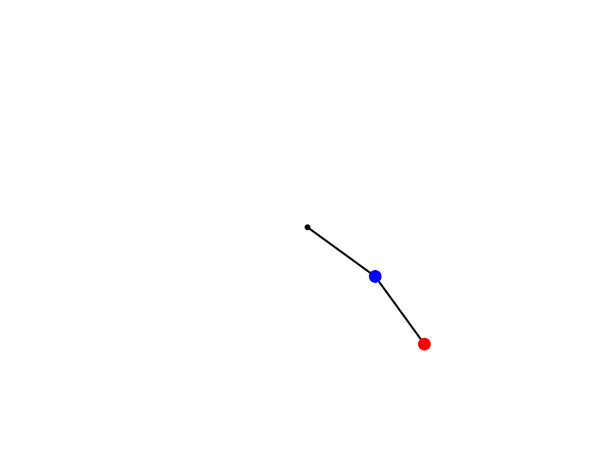

In [22]:
#>>>RUN: P13.2-runcell03

# VIEW THE GIF
# comment out the line and run again to hide

Image(open('double_p.gif','rb').read())

To analyze the motion more quantitatively, make plots of the angles and energy as functions of time. The 3$^{\textrm{rd}}$ plot shows the configuration of the system as a specific time. There are 100 images per second, so you can visualize any point in the motion by multiplying the corresponding time by 100.

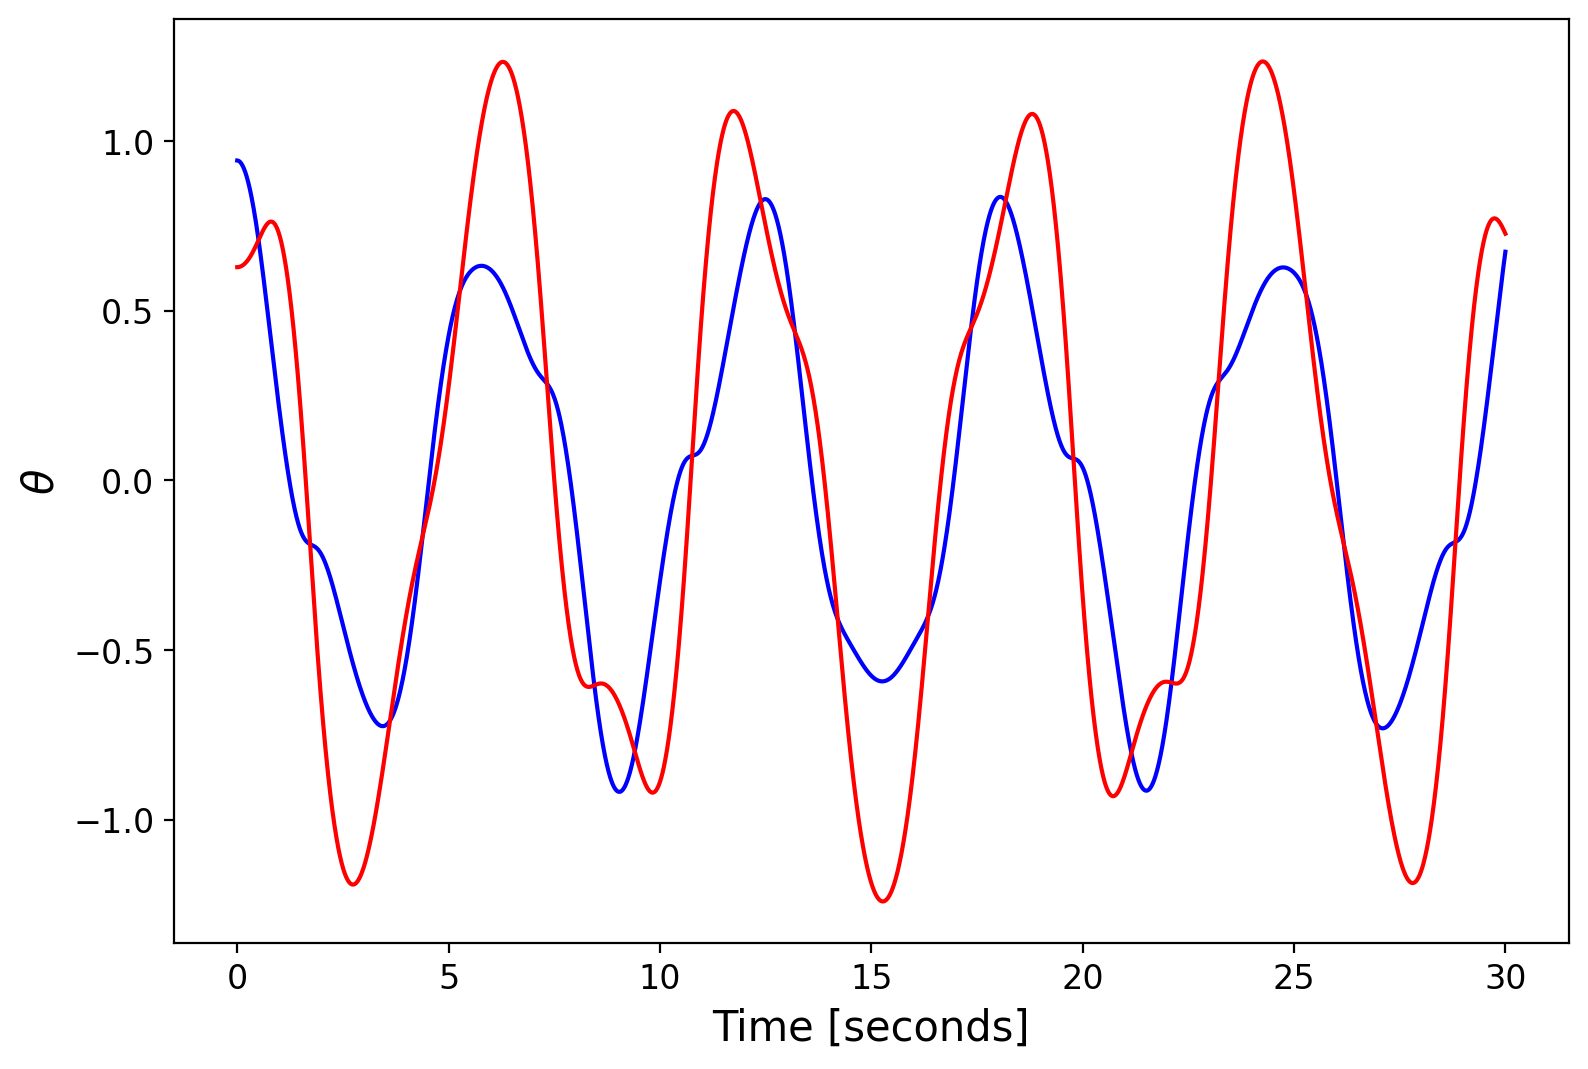

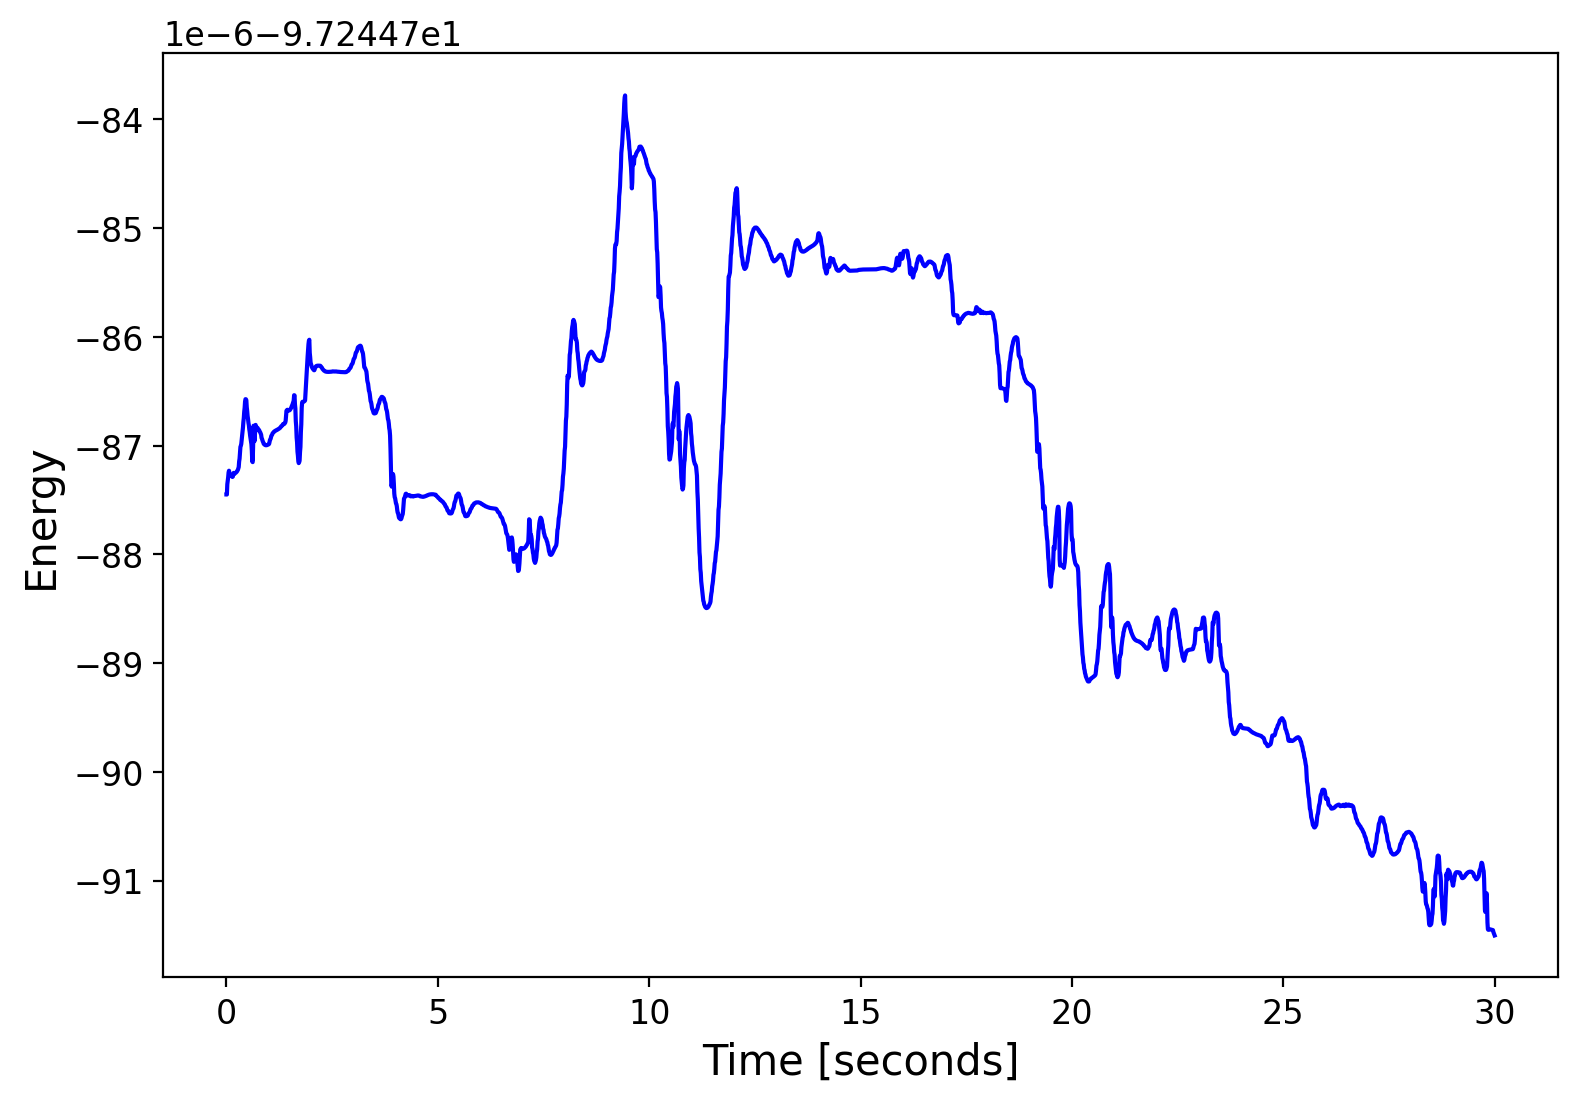

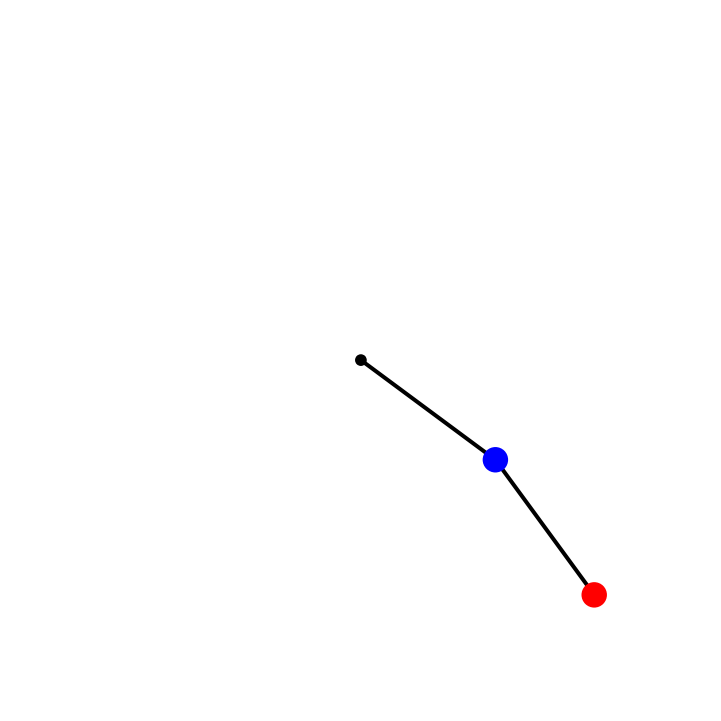

In [13]:
#>>>RUN: P13.2-runcell04

## plot the bobs' angles vs time and energy
## use previously defined y0, above

plt.plot(t,y[:,0],color='blue',label="Top pendulum angle")
plt.plot(t,y[:,2],color='red',label="Bottom pendulum angle")
plt.xlabel("Time [seconds]")
plt.ylabel(r"$\theta$")
plt.show()


plt.plot(t,en,color='blue')
plt.xlabel("Time [seconds]")
plt.ylabel("Energy")
plt.show()

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)
make_plot(10,y,l,g,ax,fig,images)
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 13.2.1</span>

For each of the following initial conditions, select the option that most closely describes the motion of the bobs. To do this, edit and run the relevant code above and analyze the plot of $\theta$ vs. $t$ for each case.

<pre>
#initial conditions:
y0_case1=np.array([0,0,0,0])
y0_case2=np.array([np.pi*0.02,0,np.pi*0.0,0])
y0_case3=np.array([np.pi*0.3,0,np.pi*0.2,0])
y0_case4=np.array([np.pi*0.9,0,np.pi*1,0])
</pre>

Select your answer for each case from the following options:

A) Stationary\
B) Both bobs oscillate periodically with constant amplitudes\
C) Both bobs oscillate periodically and display beats (i.e. the amplitudes vary up and down)\
D) Both bobs oscillate but show variations in their frequencies and amplitudes\
E) One bob oscillates periodically and one bob oscillates chaotically\
F) Both bobs oscillate chaotically


Enter your answer as a list of **uppercase** letters, corresponding to the correct choices for each set of initial conditions. For example, if the motion of the 4 cases correspond to the first 4 options in order, `[answer case1, answer case2, answer case3, answer case4 ]` should be entered as `['A','B','C','D']`. Make sure that the letters are **upper case** and listed as strings (i.e. in single quotes).

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 13.2.2</span>


Is energy conserved during the evolution for each of the above initial conditions? Try plotting the energy in each case to determine your answer.

A) Yes, the energy does not vary at all in any of the cases.\
B) Yes, there are tiny numerical variations in some cases but no significant changes over time.\
C) No, the energy fluctuates significantly as the pendulums move.\
D) No, the energy decays significantly over time.